In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim 
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader
from tqdm import tqdm

from precip.data.dataset import SwedishPrecipitationDataset, InfiniteSampler, npy_loader

device = "cpu"

In [2]:
training_dataset = SwedishPrecipitationDataset(
    split="train"
)

sampler = InfiniteSampler(training_dataset)
dataloader = DataLoader(dataset=training_dataset, sampler=sampler, batch_size=4)
dataiter = iter(dataloader)

In [3]:
from typing import Optional

def padded_reshape(x: torch.Tensor, y:torch.Tensor):
    """Aligns last two dimensions of y to x via padding"""
    diffY = x.size(-2) - y.size(-2)
    diffX = x.size(-1) - y.size(-1)
    y = F.pad(y, [diffX // 2, diffX - diffX//2, diffY //2, diffY - diffY//2])
    return y

def unet_up_collate(x: torch.Tensor, y: torch.Tensor, dim: int = 1):
    y = padded_reshape(x, y)
    return torch.cat([x, y], dim=dim)


class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, mid_channels: Optional[int] = None, kernel_size: int = 3) -> None:
        super().__init__()
        
        if mid_channels is None:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        ) 
        
        self.single_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        )
        
    def forward(self, x):
        return self.double_conv(x) + self.single_conv(x)
    

class Down(nn.Module):
    """Downscales image with maxpool and a double convolution"""
    def __init__(self, in_channels: int, out_channels: int, pool_factor: int = 2) -> None:
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(pool_factor), DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.maxpool_conv(x)
        
        
class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True) -> None:
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        return self.conv(unet_up_collate(x1, x2))

In [21]:
class EvolutionNetwork(nn.Module):
    def __init__(self, input_seq_len: int, output_seq_len: int, base_channels: int = 64, bilinear_upsample: bool = True) -> None:
        super().__init__()
        self.n_channels = input_seq_len
        self.bilinear = bilinear_upsample
        self.base_channels = base_channels
        self.output_channels = output_seq_len
        factor = 2 if self.bilinear else 1
        
        # expands dimensionality in our observation domain
        self.inc = DoubleConv(self.n_channels, self.base_channels)
        
        # iteratively downsample in spatial dimension
        self.down1 = Down(self.base_channels * 1, self.base_channels * 2)
        self.down2 = Down(self.base_channels * 2, self.base_channels * 4)
        self.down3 = Down(self.base_channels * 4, self.base_channels * 8)
        self.down4 = Down(self.base_channels * 8, self.base_channels * 16 // factor)
        
        # iteratively upsample - motion field
        self.up4 = Up(self.base_channels * 16, self.base_channels * 8 // factor, self.bilinear)
        self.up3 = Up(self.base_channels * 8, self.base_channels * 4 // factor, self.bilinear)
        self.up2 = Up(self.base_channels * 4, self.base_channels * 2 // factor, self.bilinear)
        self.up1 = Up(self.base_channels * 2, self.base_channels, self.bilinear)
        self.gamma = nn.Parameter(torch.zeros(1, self.output_channels, 1, 1), requires_grad=True)
        
        # iteratively upsample - velocity field
        self.v_up4 = Up(self.base_channels * 16, self.base_channels * 8 // factor, self.bilinear)
        self.v_up3 = Up(self.base_channels * 8, self.base_channels * 4 // factor, self.bilinear)
        self.v_up2 = Up(self.base_channels * 4, self.base_channels * 2 // factor, self.bilinear)
        self.v_up1 = Up(self.base_channels * 2, self.base_channels, self.bilinear)
        
        # collapse channels
        self.out_motion = nn.Conv2d(self.base_channels, self.output_channels, kernel_size=1)
        self.out_velocity = nn.Conv2d(self.base_channels, self.output_channels * 2, kernel_size=1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up4(x5, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        
        v = self.v_up4(x5, x4)
        v = self.v_up3(v, x3)
        v = self.v_up2(v, x2)
        v = self.v_up1(v, x1)
        
        x = self.out_motion(x) * self.gamma
        v = self.out_velocity(v)
        return x, v
    
    
def make_grid(size: tuple[int, int, int, int], cuda:bool = False):
    b, c, h, w = size
    xx = torch.arange(0, w).view(1, -1).repeat(h, 1)
    yy = torch.arange(0, h).view(-1, 1).repeat(1, w)
    
    if cuda:
        xx = xx.cuda()
        yy = yy.cuda()
    
    xx = xx.view(1, 1, h, w).repeat(b, 1, 1, 1)
    yy = yy.view(1, 1, h, w).repeat(b, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()
    
    return grid

def warp(state: torch.Tensor, flow: torch.Tensor, grid: torch.Tensor, mode='bilinear', padding_mode="zeros"):
    _, _, h, w = state.size()
    vgrid = grid + flow
    
    vgrid[:, 0, ...] = 2.0 * vgrid[:, 0, ...].clone() / max(w-1, 1) - 1.0
    vgrid[:, 1, ...] = 2.0 * vgrid[:, 1, ...].clone() / max(h-1, 1) - 1.0
    vgrid = vgrid.permute(0, 2, 3, 1)
    return F.grid_sample(state, vgrid, padding_mode=padding_mode, mode=mode, align_corners=True)
    


from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)
    

class GenerativeEncoder(nn.Module):
    FACTOR_EXPANSION = [1, 2, 4]
    
    def __init__(self, input_channels: int, base_channels: int = 64) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.base_channels = base_channels
        self.output_channel_size = GenerativeEncoder.FACTOR_EXPANSION[-1] * self.base_channels * 2
        
        self.encoder = nn.Sequential(
            DoubleConv(self.input_channels, self.base_channels, kernel_size=3),
            *[Down(self.base_channels * factor, self.base_channels * factor * 2) for factor in GenerativeEncoder.FACTOR_EXPANSION]
        )
        
    def forward(self, x):
        return self.encoder(x)


class ProjectionBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = SpectralNorm(
            nn.Conv2d(in_channels, out_channels-in_channels, kernel_size=1, padding=0)
        )
        
        self.conv2 = nn.Sequential(
            SpectralNorm(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            ),
            nn.ReLU(),
            SpectralNorm(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            )
        )
        
    def forward(self, x):
        x1 = torch.cat([x, self.conv1(x)], dim=1)
        x2 = self.conv2(x)
        return x1 + x2
    
    
class NoiseProjector(nn.Module):
    FACTOR_EXPANSION = [2, 4, 8, 16]
    
    def __init__(self, input_seq_len: int) -> None:
        super().__init__()
        
        self.input_seq_len = input_seq_len
        self.projector = nn.Sequential(
            SpectralNorm(
                nn.Conv2d(self.input_seq_len, self.input_seq_len * 2, kernel_size=3, padding=1)
            ),
            *[ProjectionBlock(self.input_seq_len * factor, self.input_seq_len * factor * 2)for factor in NoiseProjector.FACTOR_EXPANSION]
        )
        
    def forward(self, x):
        return self.projector(x)


class SequentialMultiInput(nn.Sequential):
	def forward(self, *inputs):
		for module in self._modules.values():
			if type(inputs) == tuple:
				inputs = module(*inputs)
			else:
				inputs = module(inputs)
		return inputs


class SPADE(nn.Module):
    """Spatially Additive DeNormalization"""
    def __init__(self, normalization_channels: int, label_channels: int, hidden_channels: int = 64, kernel_size: int = 3):
        super().__init__()
        
        self.param_free_norm = nn.InstanceNorm2d(normalization_channels, affine=False)
        pw = kernel_size // 2
        self.shared = nn.Sequential(
            nn.ReflectionPad2d(pw),
            nn.Conv2d(label_channels, hidden_channels, kernel_size=kernel_size, padding=0),
            nn.ReLU()
        )
        self.pad = nn.ReflectionPad2d(pw)
        self.gamma = nn.Conv2d(hidden_channels, normalization_channels, kernel_size=kernel_size, padding=0)
        self.beta = nn.Conv2d(hidden_channels, normalization_channels, kernel_size=kernel_size, padding=0)
        
    def forward(self, x, y):
        normalized = self.param_free_norm(x)
        y = F.adaptive_max_pool2d(y, output_size=x.size()[2:])
        activation = self.shared(y)
        gamma = self.gamma(self.pad(activation))
        beta = self.beta(self.pad(activation))
        return normalized * (1 + gamma) + beta
    

class GenerativeBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, prediction_length: int, dilation: int = 1, apply_second_block: bool = False) -> None:
        super().__init__()
        self.learned_shortcut = in_channels != out_channels
        self.apply_second_block = apply_second_block
        
        hidden_channels = min(in_channels, out_channels)
        self.pad = nn.ReflectionPad2d(dilation)
        
        self.first_block = SequentialMultiInput(
            SPADE(in_channels, prediction_length),
            nn.LeakyReLU(negative_slope=2e-1),
            self.pad,
            SpectralNorm(
                nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=0, dilation=dilation)
            )
        )
        
        if apply_second_block:
            self.second_block = SequentialMultiInput(
                SPADE(hidden_channels, prediction_length),
                nn.LeakyReLU(negative_slope=2e-1),
                self.pad,
                SpectralNorm(
                    nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=0, dilation=dilation)
                )
            )

        
        if self.learned_shortcut:
            self.shortcut_module = SequentialMultiInput(
                SPADE(in_channels, prediction_length),
                SpectralNorm(
                    nn.Conv2d(in_channels, hidden_channels, kernel_size=1, padding=0, dilation=dilation)
                )
            )
        else:
            self.shortcut_module = self._shortcut_identity
            
    def _shortcut_identity(self, x, y):
        return x
    
    def forward(self, x, y):
        x_shortcut = self.shortcut_module(x, y)
        dx = self.first_block(x, y)
        
        if self.apply_second_block:
            dx = self.second_block(dx, y)
        
        return dx + x_shortcut
    

class GenerativeDecoder(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, base_channels: int = 64) -> None:
        super().__init__()
        # self.upsample = nn.Upsample(scale_factor=2)
        # self.conv = nn.Conv2d(input_channels, 8 * base_channels, kernel_size=3, padding=1)
        # self.gen_0 = GenerativeBlock(8 * base_channels, 8 * base_channels)
        # self.gen1
        
        self.up = nn.Upsample(scale_factor=2)
        self.conv_in = nn.Conv2d(input_channels, 8 * base_channels, kernel_size=3, padding=1)
        
        # self.gen0 = SequentialMultiInput(
        #     GenerativeBlock(8 * base_channels, 8 * base_channels, prediction_length=output_channels),
        #     self.up
        # ) 
        # self.gen1 = SequentialMultiInput(
        #     GenerativeBlock(8 * base_channels, 4 * base_channels, prediction_length=output_channels),
        #     self.up
        # )
        # self.gen2 = SequentialMultiInput(
        #     GenerativeBlock(4 * base_channels, 2 * base_channels, prediction_length=output_channels),
        #     self.up,
        # )
        # self.gen3 = GenerativeBlock(2 * base_channels, base_channels, prediction_length=output_channels)
        # self.gen4 = SequentialMultiInput(
        #     GenerativeBlock(base_channels, base_channels, prediction_length=output_channels),
        #     nn.LeakyReLU(negative_slope=2e-1)
        # )
        
        self.generative_blocks = nn.ModuleList(
            [
                SequentialMultiInput(
                    GenerativeBlock(8 * base_channels, 8 * base_channels, prediction_length=output_channels),
                    self.up
                ),
                SequentialMultiInput(
                    GenerativeBlock(8 * base_channels, 4 * base_channels, prediction_length=output_channels),
                    self.up
                ),
                SequentialMultiInput(
                    GenerativeBlock(4 * base_channels, 2 * base_channels, prediction_length=output_channels),
                    self.up
                ),
                GenerativeBlock(2 * base_channels, base_channels, prediction_length=output_channels),
                SequentialMultiInput(
                    GenerativeBlock(base_channels, base_channels, prediction_length=output_channels),
                    nn.LeakyReLU(negative_slope=2e-1)
                )
            ]
            
        )
        
        self.conv_out = nn.Conv2d(base_channels, output_channels, kernel_size=3, padding=1)
        
            
        # self.module = SequentialMultiInput(
        #     nn.Conv2d(input_channels, 8 * base_channels, kernel_size=3, padding=1),
        #     GenerativeBlock(8 * base_channels, 8 * base_channels),
        #     self.up,
        #     GenerativeBlock(8 * base_channels, 4 * base_channels),
        #     self.up,
        #     GenerativeBlock(4 * base_channels, 2 * base_channels),
        #     self.up,
        #     GenerativeBlock(2 * base_channels, base_channels),
        #     GenerativeBlock(base_channels, base_channels),
        #     nn.LeakyReLU(negative_slope=2e-1),
        #     nn.Conv2d(base_channels, output_channels, kernel_size=3, padding=1)
        # )
        
    def forward(self, x, y):
        # TODO - tidy this up
        x = self.conv_in(x)
        # print(x.shape)
        # print(y.shape)
        # x = self.gen0(x, y)
        # print(x.shape)
        # print(y.shape)
        # x = self.gen1(x, y)
        # x = self.gen2(x, y)
        # x = self.gen3(x, y)
        # x = self.gen4(x, y)
        
        for gen_block in self.generative_blocks:
            x = gen_block(x, y)
        
        return self.conv_out(x)


class NowcastNet(nn.Module):
    def __init__(self, input_seq_len, output_seq_len) -> None:
        super().__init__()
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        
        self.evolution_network = EvolutionNetwork(self.input_seq_len, self.output_seq_len, 4)
        self.generative_encoder = GenerativeEncoder(input_seq_len + output_seq_len)
        self.noise_projector = NoiseProjector(32)
        self.generative_decoder = GenerativeDecoder(input_channels=(self.generative_encoder.output_channel_size + 64), output_channels=self.output_seq_len)
        self.grid = make_grid((1, 1, 256, 256))
        
    def forward(self, x: torch.Tensor):
        b, t, h, w = x.size()
        intensity, motion = self.evolution_network(x)
        _motion = motion.reshape(b, self.output_seq_len, 2, h, w)
        _intensity = intensity.reshape(b, self.output_seq_len, 1, h, w)
        
        latest_frame = x[:, :1, ...]
        grid = self.grid.repeat(b, 1, 1, 1)
        
        steps = []
        for i in range(self.output_seq_len):
            latest_frame = warp(latest_frame, _motion[:, i], grid, mode="nearest", padding_mode="border")
            latest_frame = latest_frame + _intensity[:, i]
            steps.append(latest_frame)
            
        evolution_result = torch.cat(steps, dim=1)
        evo_feature = self.generative_encoder(torch.cat([x, evolution_result], dim=1))
        
        noise = torch.randn(1, 32, 256 //32, 256 //32)
        noise_f = self.noise_projector(noise)
        
        ngf = 32

        noise = torch.randn(b, ngf, 256 //32, 256 //32)
        nproj = NoiseProjector(32)
        noise_f = nproj(noise).reshape(1, -1, 4, 4, 8, 8).permute(0, 1, 4, 5, 2, 3).reshape(b, -1, 256 //8, 256 //8)
        
        print(evo_feature.shape)
        print(noise_f.shape)
        
        # build input to generative decoder
        feature = torch.cat([evo_feature, noise_f], dim=1)
        return self.generative_decoder(feature, evolution_result)
        
        

In [22]:
(batch_X, batch_y) = next(dataiter)

In [23]:
batch_X.shape

torch.Size([4, 12, 256, 256])

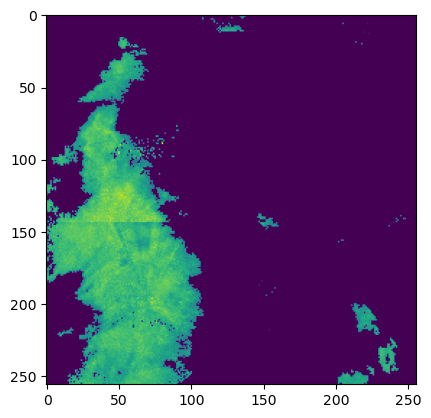

In [24]:
plt.imshow(batch_X[0, 0].detach().numpy())

In [25]:
model = NowcastNet(12, 1)

In [26]:
p = model(batch_X)

torch.Size([4, 512, 32, 32])
torch.Size([4, 64, 32, 32])


In [28]:
p.shape

torch.Size([4, 1, 256, 256])

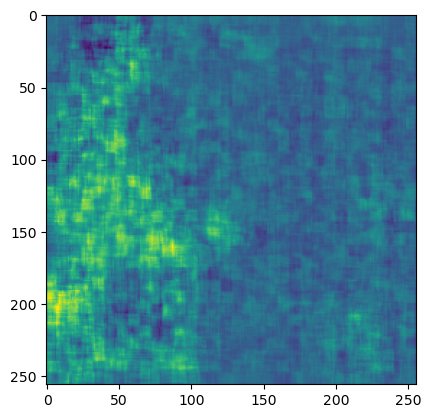

In [29]:
plt.imshow(p[0, 0].detach().numpy())